In [74]:
import sys
import os
import cv2
import numpy as np

import copy
import random
from PIL import Image
import seaborn as sns 
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot

import keras
import tensorflow as tf
from keras import layers
from keras import optimizers
from keras import regularizers
from keras import backend as K
from keras.optimizers import adam 

from keras.models import Sequential
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator


from urllib.request import urlopen
from keras import models
from keras import optimizers
from keras import callbacks
from keras import losses
from keras import regularizers
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,GlobalAveragePooling2D, Convolution2D
from keras.layers import Activation, Dense
from keras import optimizers 
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D,ZeroPadding2D
from keras.optimizers import SGD
from keras.layers  import BatchNormalization



from sklearn.decomposition import PCA
from tensorflow.keras.optimizers import SGD
import math
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from keras.regularizers import Regularizer
from urllib.request import urlopen


# import libary albumentation for augmentation data

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose
)


### Read Dataset

In [39]:
img_fps_train  = '/home/manhduy/Documents/model_DL/Project_Intern/Data/102_flower_dataset/train'
img_fps_test   = '/home/manhduy/Documents/model_DL/Project_Intern/Data/102_flower_dataset/test'
img_fps_validation = '/home/manhduy/Documents/model_DL/Project_Intern/Data/102_flower_dataset/valid'

In [40]:
def wfile_data(root): 
    fp = []
    for path, subdirs, file in os.walk(root): 
        for name in file: 
            fp.append(os.path.join(path,name))
    return sorted(fp)

In [41]:
X_train = wfile_data(img_fps_train)
X_test  = wfile_data(img_fps_test)
X_valid = wfile_data(img_fps_validation)
Y_train = []
Y_test = []
Y_valid = []

In [42]:
for path in X_train: 
    Y_train.append(int(path.split("/")[-2])-1)
for path in X_test: 
    Y_test.append(int(path.split("/")[-2])-1)
for path in X_valid: 
    Y_valid.append(int(path.split("/")[-2])-1)
len(X_train),len(Y_train),len(X_valid),len(Y_valid),len(X_test),len(Y_test)




(17071, 17071, 2435, 2435, 1486, 1486)

### Data Generator

In [44]:
class Generator_Augmentation(keras.utils.Sequence): 
    """data generator for classifiction"""
    def __init__(self,
                 root_file, 
                 label, 
                 batch_size = 8, 
                 img_shape = (224,224), 
                 no_channels = 3, 
                 no_classes = 102, 
                 augmentation = True,
                 shuffle = True): 
    
        self.img_shape = img_shape 
        self.no_channels = no_channels
        self.no_classes = no_classes 
        self.batch_size = batch_size 

        self.augmentation = augmentation 

        self.root_file = root_file 
        self.label = label 
        
        print(" >>>>>>> batch_size : {} image".format(self.batch_size))
        self.ids = range(len(self.root_file))   # len cua file data. 
        assert len(self.root_file) == len(self.label)
        self.shuffle = shuffle 
        self.on_epoch_end() 

        
    def __len__(self): 
        return int(np.floor(len(self.ids) / self.batch_size))
    
    def __getitem__(self, index): 
        indexes_array = self.indexes_array[index*self.batch_size : (index + 1) * self.batch_size]
#         print(index)
#         print(indexes_array)
        
        array_ids = [self.ids[k] for k in indexes_array]
#         print(array_ids)
        x, y = self.__data_generator(array_ids)
        
        return x, y 
    
    def on_epoch_end(self): 
        self.indexes_array = np.arange(len(self.ids))
        if self.shuffle: 
            np.random.shuffle(self.indexes_array)
    
      
    
    def strong_aug(self,p=0.5):
        return Compose([
            RandomRotate90(),  # lat ,xoay, room image
            Flip(),
            Transpose(),
            OneOf([   # add noise
                IAAAdditiveGaussianNoise(),  
                GaussNoise(),
            ], p=0.2),
            OneOf([
                MotionBlur(p=.2),
                MedianBlur(blur_limit=3, p=0.1),  # add coler
                Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2), # dich image
            OneOf([
                OpticalDistortion(p=0.3),
                GridDistortion(p=.1),
                IAAPiecewiseAffine(p=0.3),
            ], p=0.2),
            OneOf([
                CLAHE(clip_limit=2),
                IAASharpen(),
                IAAEmboss(),
                RandomBrightnessContrast(),     # thay doi do sang       
            ], p=0.3),
            HueSaturationValue(p=0.3),
        ], p=p)
    
    def __data_generator(self, array_ids): 
        
        x = np.empty ( (0, *self.img_shape, self.no_channels), dtype=np.float32)
        y = []
        
        for index, id in enumerate(array_ids): 
            img_path = self.root_file[id] 
            label_curr    = self.label[id]
            
            image = cv2.imread(img_path)[:,:,::-1]
            if self.augmentation: 
                image = self.strong_aug(p=1)(image=image)['image']
            image = cv2.resize(image,self.img_shape) 
            image = image / 255 
            image = image.astype(np.float32)
           
            image = np.expand_dims(image, axis = 0)
            x = np.vstack((x,image))
            y.append(label_curr)
        y = keras.utils.to_categorical(y,num_classes= self.no_classes, dtype= np.float32)
        # explane vector onehot coding 102 in last channels 
        return x, y
    
    

In [45]:
input_shape_flower = (384,384,3)
batch_size = 16 
epochs = 10
n_classes = 102
n_channels = 3
train_size  = len(X_train)
valid_size  = len(X_valid)
input_shape = (384,384)
print(train_size,valid_size)

param = {  'batch_size' : batch_size, # define params in Generator 
            'img_shape': (384,384), 
            'no_channels' : 3, 
            'no_classes' : 102, 
            'augmentation' : True, 
            'shuffle' : True}

17071 2435


In [46]:
data_generator = Generator_Augmentation(X_train,Y_train, **param )
valid_generator = Generator_Augmentation(X_valid,Y_valid, **param )
len(data_generator)  # step per epoch 

 >>>>>>> batch_size : 16 image
 >>>>>>> batch_size : 16 image


1066

In [47]:
x,y = data_generator[0]


In [48]:
x.shape, y.shape

((16, 384, 384, 3), (16, 102))

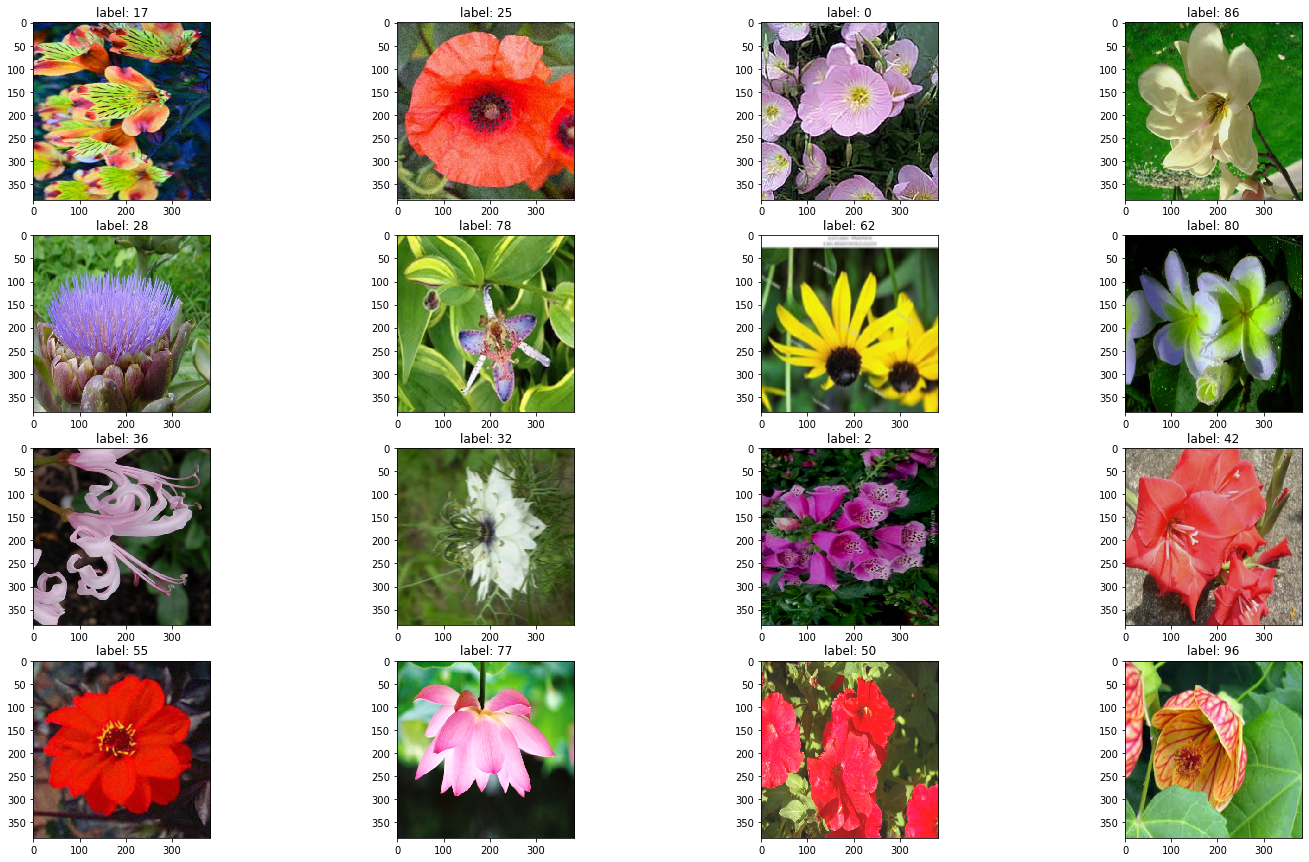

In [49]:
plt.figure(figsize = (25,15))  # plot all batch_size in generator and augmentation data in train data set
for i in range(batch_size):
    plt.subplot(4,4, i+1)
    img = x[i]
    label_class = np.argmax(y[i])
    plt.title( "label: {}".format(str(label_class)))
    plt.imshow(img)

In [50]:
a, b = valid_generator[0]

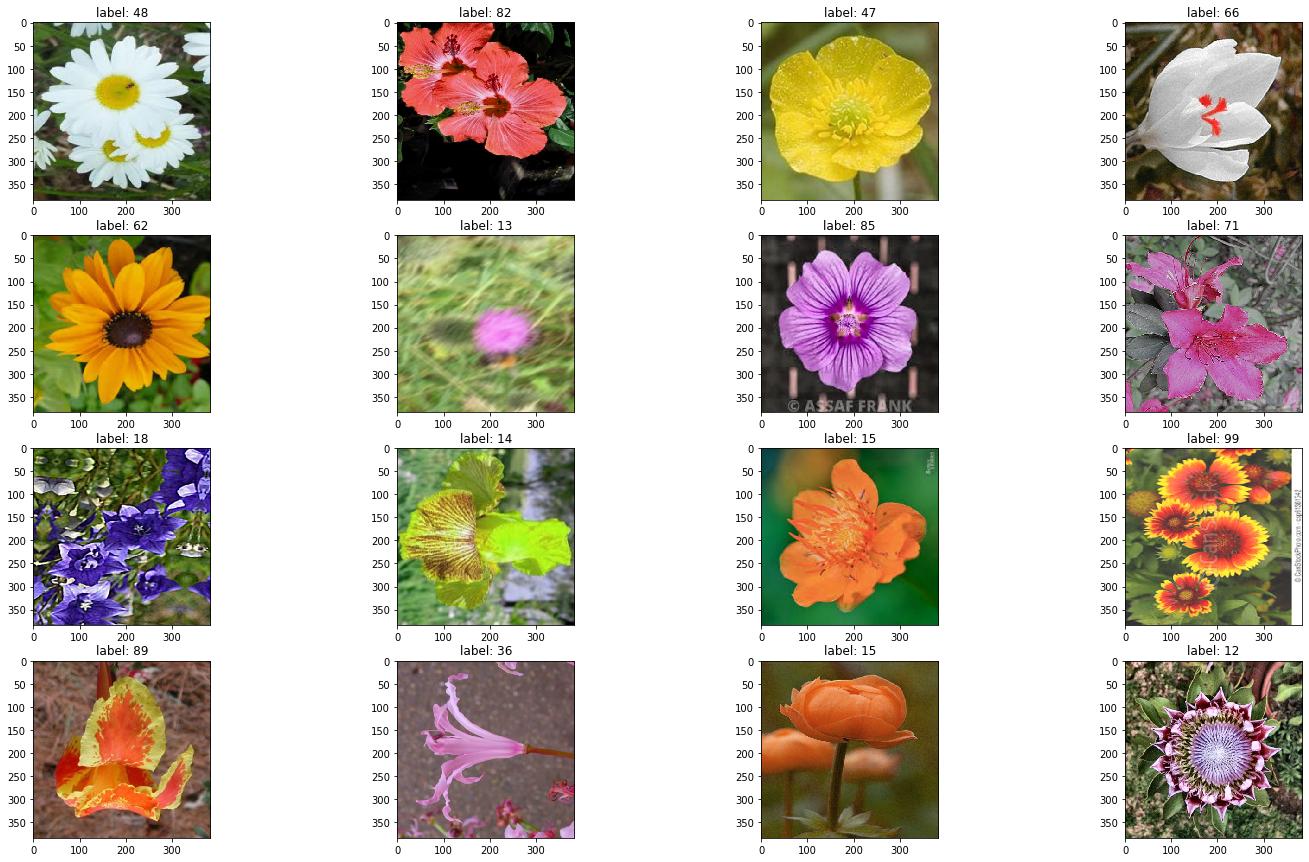

In [51]:
plt.figure(figsize = (25,15)) # plot all batch_size in generator and augmentation data in valid data set
for i in range(batch_size):
    plt.subplot(4,4, i+1)
    img = a[i]
    label_class = np.argmax(b[i])
    plt.title( "label: {}".format(str(label_class)))
    plt.imshow(img)

In [52]:
#define CNN models 
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu', padding = 'same',input_shape = input_shape_flower))
model.add(BatchNormalization())   # normalization weight output every singer layers
model.add(Conv2D(32,(3,3),activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))


model.add(Conv2D(32,(3,3),activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64,(3,3),activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64,(3,3),activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128,(3,3),activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(256,(3,3),activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),activation='relu', padding = 'same'))
model.add(BatchNormalization())  # normalization weight output every singer layers
model.add(MaxPooling2D(pool_size = (2,2))) 


model.add(Flatten())  # fully conected
model.add(Dense(512,activation= 'relu'))
model.add(Dropout(0.25))
model.add(Dense(102, activation='softmax'))


In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 384, 384, 32)      896       
_________________________________________________________________
batch_normalization_13 (Batc (None, 384, 384, 32)      128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 384, 384, 32)      9248      
_________________________________________________________________
batch_normalization_14 (Batc (None, 384, 384, 32)      128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 192, 192, 32)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 192, 192, 32)      9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 192, 192, 32)     

In [54]:
import keras 
# save model when improve accuracy models
save_best = keras.callbacks.ModelCheckpoint('/home/manhduy/Documents/model_DL/check_model.h5',
                                           monitor = 'accuracy', verbose = 1, save_best_only = True)
# stop trainning wuehn valu_accuracy not improve. 
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                          min_delta = 0, patience = 10, 
                                          verbose = 1)

In [55]:
# define caculate F1 score
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [56]:
# model.save_weights('/content/gdrive/My Drive/Colab_Notebooks/weight3_best_version.h5')
model.load_weights('/home/manhduy/Documents/model_DL/Project_Intern/weights/best_weight_version3.h5')
# model.summary()

In [57]:
from keras import metrics
print( " == Compiling Model ==")

# using SGD with momentum and nesterov
sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov= True)
# adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer = sgd, 
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor = 'accuracy',
                              factor=0.1,
                              patience = 2, 
                              min_lr=0.00000000001)

callbacks = [reduce_lr, save_best, early_stop]

 == Compiling Model ==


### Train Models

In [58]:
# history = model.fit_generator(generator=data_generator,
#                     steps_per_epoch=len(data_generator),
#                     validation_steps = len(valid_generator), 
#                     validation_data=valid_generator,
#                     epochs= 15, 
#                     verbose = 1,
#                     callbacks=callbacks, 
#                     shuffle=True)

### Plot History

In [59]:

# def train_model_show(_history):
#     ## plot some result
#     fig, (ax1, ax2 ) = plt.subplots(2, 1, figsize = (20, 15))
#     # plot train and val loss
#     ax1.plot(history.history['loss'], label = 'Train_loss')
#     ax1.plot(history.history['val_loss'], label = 'Val_loss')
#     ax1.set_title('Train_loss and Val_loss')
#     ax1.set_ylabel('loss')
#     ax1.set_label('epochs')
#     ax1.legend()

#     # plot train and val accuracy
#     ax2.plot(history.history['val_accuracy'], label = 'val_accuracy')
#     ax2.plot(history.history['accuracy'], label = 'accuracy')
#     ax2.set_title('val accuracy and accuracy')
#     ax2.set_ylabel('acc')
#     ax2.set_label('epochs')
#     ax2.legend()
#     plt.show()
    
# def learning_rate (history):
# #     fig, ax1 = plt.subplot( figsize = (25,10))
#     plt.figure(figsize = (10,5))
#     plt.plot(history.history['lr'], label = 'Learning rate')
#     plt.title('Learning rate')
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.legend()
#     plt.show()

# train_model_show(history) 
# learning_rate(history)

### Predict Models 

In [60]:
input_shape = (384,384)
def Preprocessing_Image(img_fps_path):
    img = cv2.imread(img_fps_path)[:,:,::-1]

    img = cv2.resize(img,(384,384))
    img = img.astype(np.float32)
    img = img / 255
    img = np.expand_dims(img, axis=0)  
    return img 

In [61]:
print(len(X_test),len(Y_test))

1486 1486


### accuracy of models 

In [62]:
from sklearn.metrics import accuracy_score 

In [63]:
y_pre = []
y_true = Y_test

for path_image_test in X_test: 
    image = Preprocessing_Image(path_image_test)
    x = model.predict(image)
    xx = np.argmax(x) 
    y_pre.append(xx) 


In [64]:
num_accuracy = accuracy_score(y_true,y_pre)
num_accuracy

0.8566621803499327

In [65]:
import sklearn 
report_classification = sklearn.metrics.classification_report (y_true,y_pre)

In [66]:
print(report_classification)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       1.00      1.00      1.00        12
           2       0.43      0.60      0.50        20
           3       0.50      0.31      0.38        13
           4       0.93      0.93      0.93        14
           5       1.00      0.84      0.91        19
           6       0.90      0.69      0.78        13
           7       0.90      1.00      0.95        18
           8       0.79      0.73      0.76        15
           9       1.00      1.00      1.00        16
          10       0.60      0.67      0.63         9
          11       0.86      0.67      0.75         9
          12       1.00      1.00      1.00        12
          13       1.00      0.79      0.88        14
          14       0.69      0.60      0.64        15
          15       0.93      0.93      0.93        15
          16       0.62      1.00      0.76        13
          17       0.80    

In [67]:
path_test_image = '/home/manhduy/Documents/model_DL/Project_Intern/test_image/img7.jpeg'

16


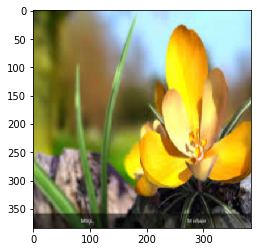

In [68]:
image_test =Preprocessing_Image(path_test_image) 

plt.imshow(image_test[0])
pre_image = model.predict(image_test)
labels_predict = np.argmax(pre_image) + 1
print(labels_predict)

In [75]:
# tao ra array result sau predict labels 
result_predict = []  
cnt = 0
for index, value in enumerate(Y_train): 
    if value == labels_predict - 1 and cnt <= batch_size: 
        result_predict.append(index) 
        cnt  = cnt + 1


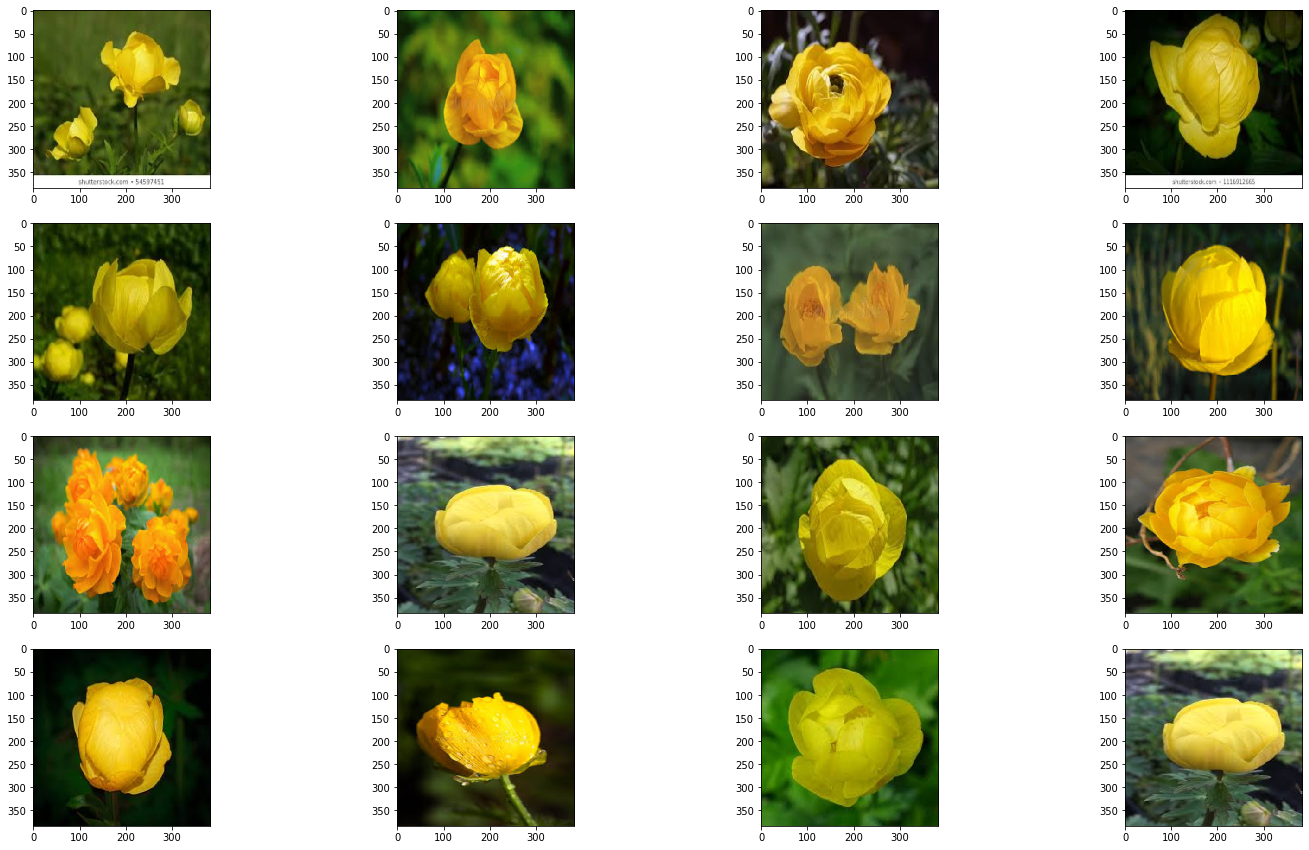

In [70]:
plt.figure(figsize = (25,15))
for i in range(batch_size):
    plt.subplot(4,4, i+1)
    image = Preprocessing_Image(X_train[result_predict[i]])[0]
    label_class = labels_predict
#     plt.title( "label: {}".format(str(label_class)))
    plt.imshow(image)

In [71]:
# tao ra one hot coding 102 with shape of test dataset for plot confusion matrix
arr = np.empty( 0, dtype = np.float32 )
new_arr = keras.utils.to_categorical(arr, num_classes=102)


for fps_path in X_test: 
    new_img  = model.predict(Preprocessing_Image(fps_path))
    new_arr = np.vstack((new_arr,new_img))

y_true=np.argmax(new_arr, axis=-1)
flat_array = np.asarray(Y_test)

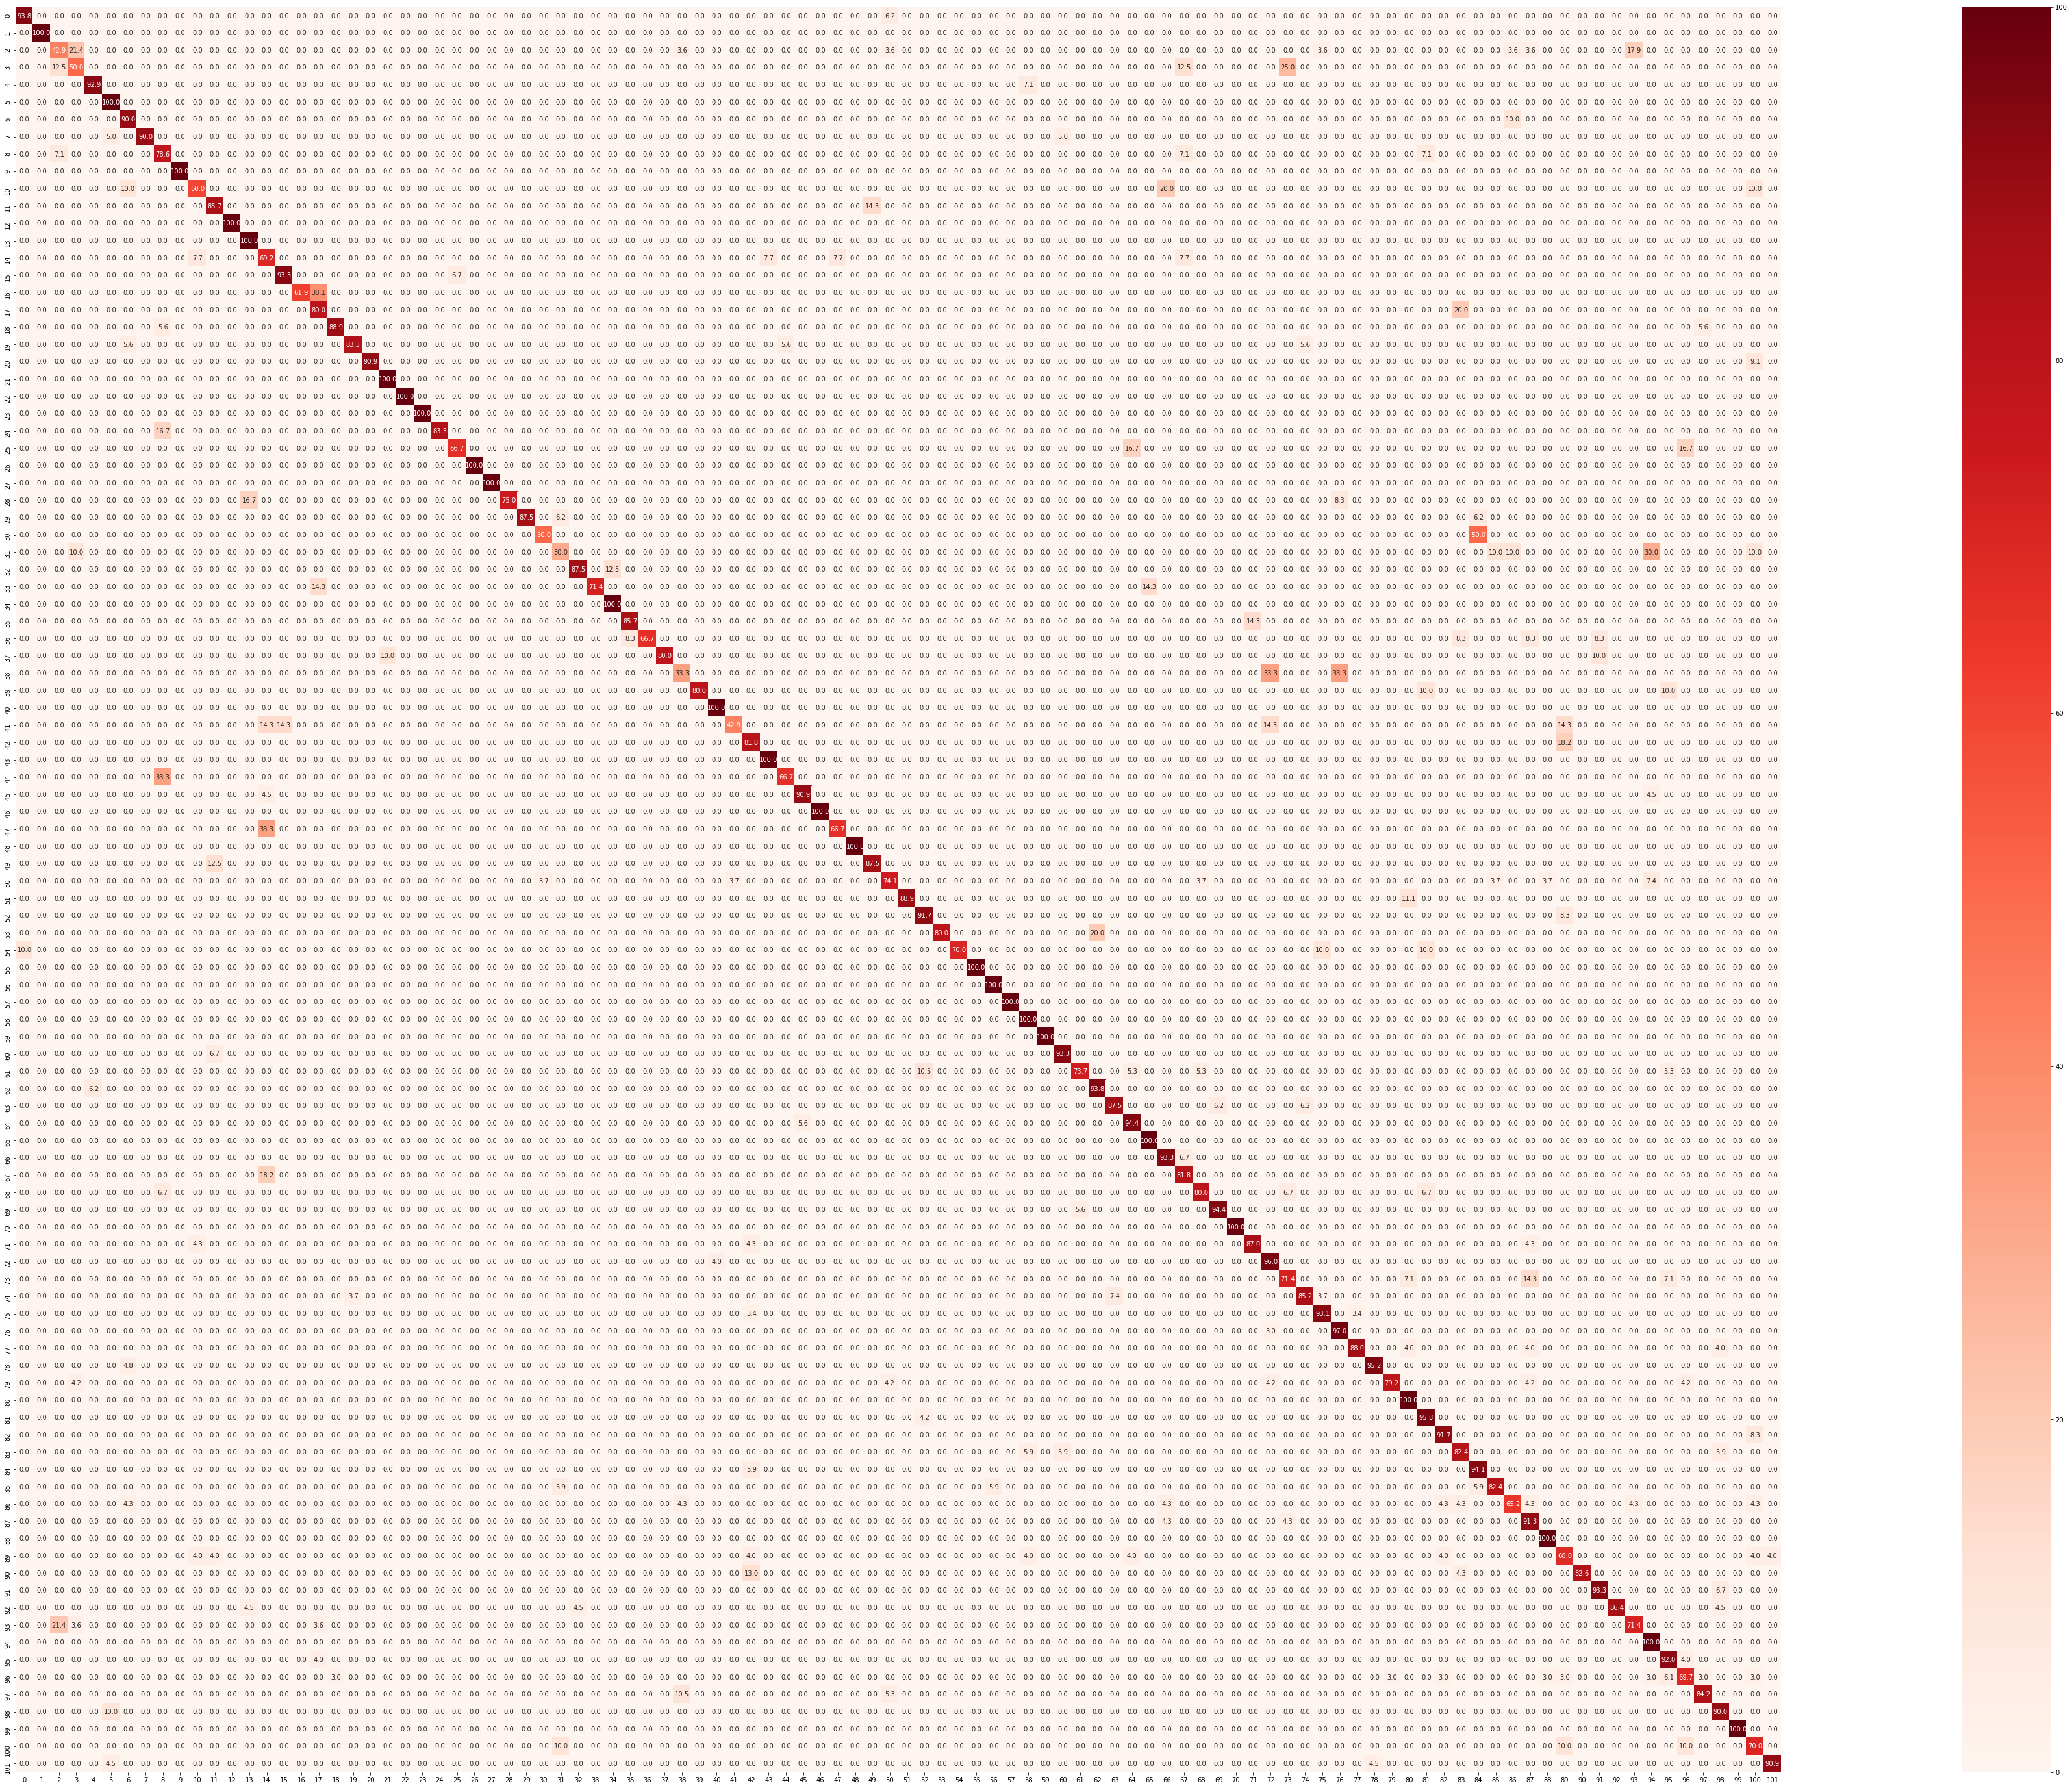

In [72]:
# plot confusion matrix with 92% accuracy in train models 
from sklearn.metrics import confusion_matrix

# Set the figure size
plt.figure(figsize=(100, 50))

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred=flat_array)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True)